In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Star Dataset from: 
https://www.kaggle.com/datasets/deepu1109/star-dataset

In [21]:
df = pd.read_csv("stars.csv")
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [22]:
import re

# df.isnull().sum()
# df["Star type"].unique()

# print(df[df['Star color'] == "Blue-white"]["Star type"])
# print(df[df['Star color'] == "Blue White"]["Star type"])

def preprocess_color(color_name):
  new_name = color_name.replace(" ", "-").lower()
  if new_name[-1] == '-':
    new_name = new_name[:-1]
  if new_name == "yellow-white":
    new_name = "white-yellow"
  return new_name

# print(df['Star color'].value_counts())
df['Star color'] = df['Star color'].apply(preprocess_color)

df = df[[col for col in df if col not in ['Star type']] + ['Star type']]
df.head()
# data = [8, 8, 9, 12, 13, 13, 14, 14, 15, 18, 22, 23, 24, 25, 30]
# fig, ax = plt.subplots()
# ax.hist(df["Star color"], edgecolor="black")

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color,Spectral Class,Star type
0,3068,0.002400,0.1700,16.12,red,M,0
1,3042,0.000500,0.1542,16.60,red,M,0
2,2600,0.000300,0.1020,18.70,red,M,0
3,2800,0.000200,0.1600,16.65,red,M,0
4,1939,0.000138,0.1030,20.06,red,M,0


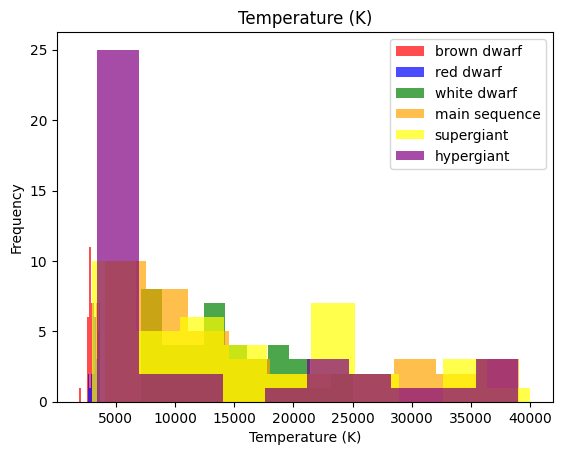

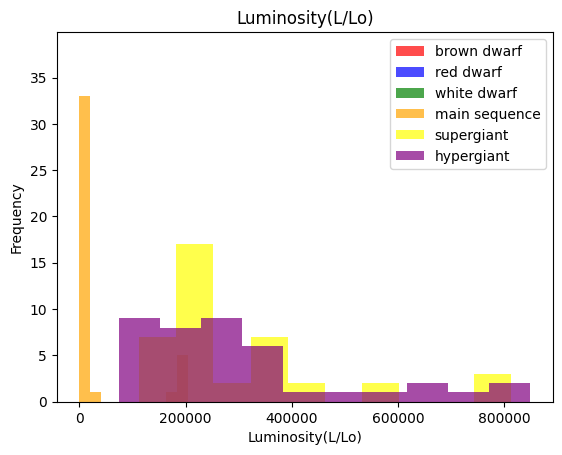

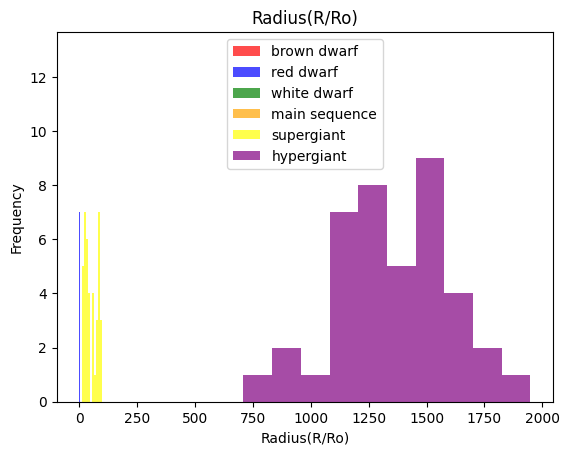

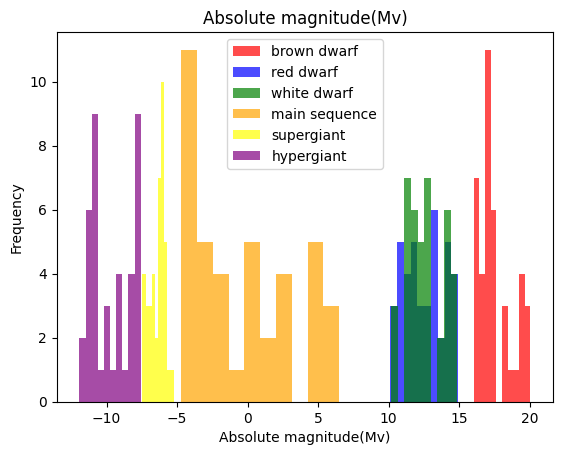

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


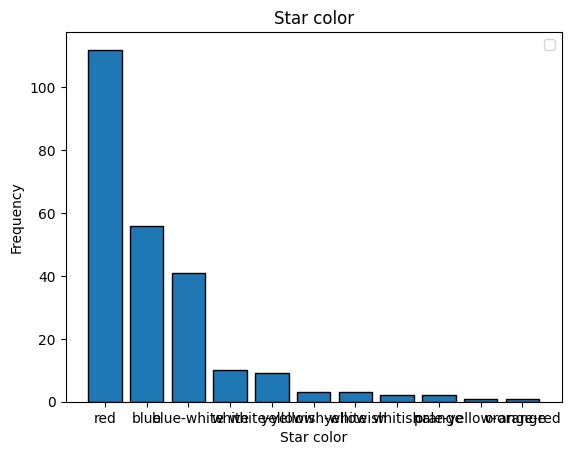

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


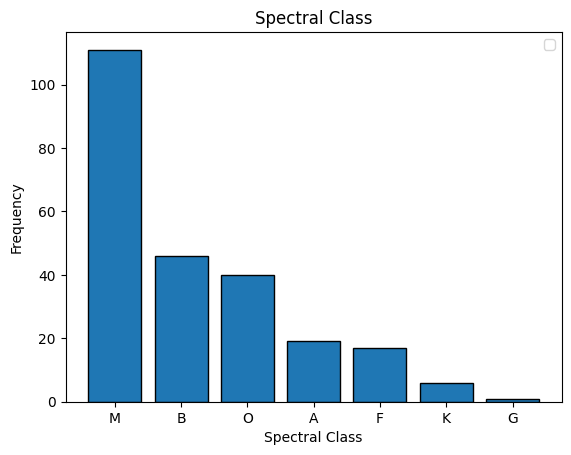

In [9]:
colors = ["red", "blue", "green", "orange", "yellow", "purple"]
labels = ["brown dwarf", "red dwarf", "white dwarf", "main sequence", "supergiant", "hypergiant"] # from repo https://github.com/ACM-Research/coding-challenge-2023-spring
for label in df.columns:
  # Plot histogram of each column for each star type
  if label == "Star type":
    continue;
  if label == "Star color" or label == "Spectral Class":
    plt.bar(df[label].value_counts().index, df[label].value_counts().values, edgecolor="black")
  else: 
    for star_type in range(6):
      plt.hist(df[df['Star type'] == star_type][label], color=colors[star_type], label=labels[star_type], alpha=0.7, density=False) 
  plt.ylabel("Frequency")
  plt.title(label)
  plt.xlabel(label)
  plt.legend()
  plt.show()


# Train, validation, test datasets

In [23]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))]) # 60-20-20

In [12]:
def preprocess(dataframe):
  columns_to_encode = ["Star color", "Spectral Class"]
  columns_to_scale = ["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)"]
  
  scaler = StandardScaler()
  ohe = OneHotEncoder()